In [2]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import random
import subprocess
from pagexml.parser import parse_pagexml_file
from pagexml.model.pagexml_document_model import PageXMLTextLine, PageXMLTextRegion, PageXMLPage
import sys
from shutil import copy
from dotenv import dotenv_values

from shapely.geometry.linestring import LineString
from shapely.geometry.multilinestring import MultiLineString

PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))


dotenv_dict = dotenv_values(PROJECT_DIR / ".env")
DATA_DIR = Path(dotenv_dict["POLIS_DATA_DIR"])



In [3]:
# Helpers
def random_color():
    return (random.random(), random.random(), random.random())  # RGBA with transparency


def show_image(image_masks: list[dict], image_path: str, size: int=10):
    file_name = Path(image_path).name

    colors = [random_color() for _ in range(len(image_masks))]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(size, size))

    # Show the image
    image = Image.open(image_path)
    ax.imshow(image)

    # Draw the bounding box
    for idx, ann in enumerate(image_masks):
        bbox = ann["bbox"]
        segm = ann["segmentation"][0]
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor='lime', facecolor='none', label="Bounding Box"
        )
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1] - 10, str(idx), color = "lime", size=11)

        # Draw the segmentation mask
        seg_x = segm[0::2]
        seg_y = segm[1::2]
        ax.fill(seg_x, seg_y, facecolor=colors[idx], alpha=0.4, edgecolor=colors[idx], linewidth=2, label="Segmentation")

    # Set axis limits
    ax.set_xlim(0, image.width)
    ax.set_ylim(image.height, 0)  # Invert y-axis to match image coordinates

    # Labels and legend
    ax.set_title(file_name)
    # ax.legend()

    # Show the plot
    plt.show()

# Poliskammare

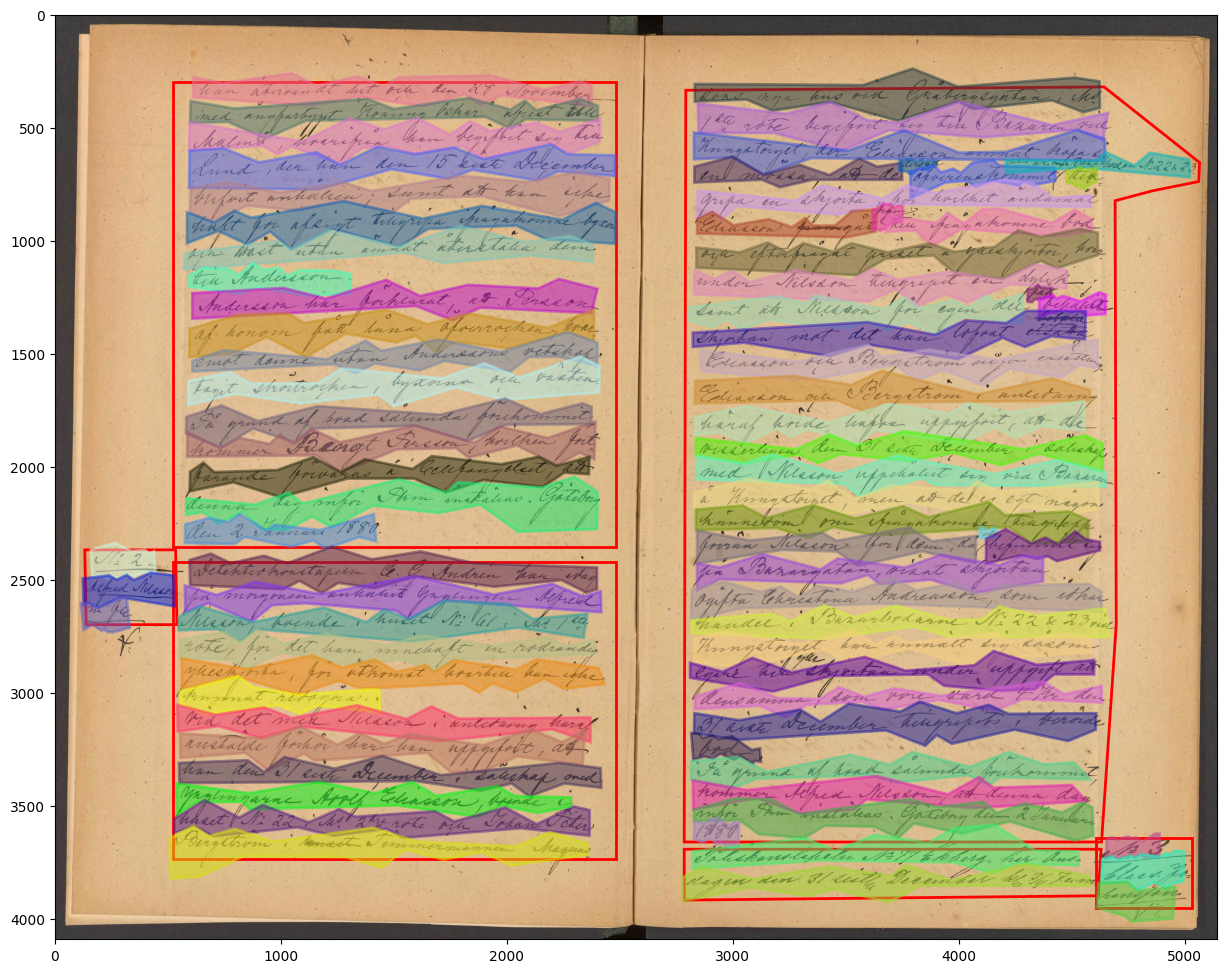

In [5]:
# Visualize poliskammare

file_idx = 2

image_files = sorted(DATA_DIR.glob(pattern="images/**/*.tif"))
xml_files = sorted(DATA_DIR.glob(pattern="page_xmls/**/*.xml"))

image_path = image_files[file_idx]
xml_path = xml_files[file_idx]

# image_path = "/Users/hoanghapham/Projects/thesis-data/poliskammare/images/Göteborgs_poliskammare_före_1900__A_II__27__1895_/Göteborgs_poliskammare_före_1900__A_II__27__1895__30002048_00080.tif"
# xml_path = "/Users/hoanghapham/Projects/thesis-data/poliskammare/page_xmls/Göteborgs_poliskammare_före_1900__A_II__27__1895_/Göteborgs_poliskammare_före_1900__A_II__27__1895__30002048_00080.xml"

def construct_line_bbox(line: PageXMLTextLine):
    seg_x = [x for (x, y) in line.coords.points]
    seg_y = [y for (x, y) in line.coords.points]
    anchor_x = min(seg_x)
    anchor_y =  min(seg_y)
    width = max(seg_x) - min(seg_x)
    height = max(seg_y) - min(seg_y)

    return anchor_x, anchor_y, width, height


def show_poliskammare_img(image_path: str, xml_path: str, show_large_bbox=False, show_line_bbox=False, fig_size=15):

    # Get data
    content = parse_pagexml_file(xml_path)
    region_data = content.get_regions()
    line_data = content.get_lines()


    # Show image
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    image = Image.open(image_path)
    ax.imshow(image)


    # Color for lines
    line_colors = [random_color() for _ in range(len(line_data))]

    if show_large_bbox:
        # Draw bbox for each large region
        for idx, region in enumerate(region_data):
            bbox = region.coords.points

            # bbox is not guaranteed to be a rectangle, and can actually be of weird shapes
            rect = patches.Polygon(
                bbox,
                linewidth=2, edgecolor='r', facecolor='none', label="Bounding Box"
            )
            ax.add_patch(rect)


    # Color lines
    for idx, poly in enumerate(line_data):
        seg_x = [x for (x, y) in poly.coords.points]
        seg_y = [y for (x, y) in poly.coords.points]
        ax.fill(
            seg_x, seg_y, 
            facecolor=line_colors[idx], 
            alpha=0.5, 
            edgecolor=line_colors[idx], 
            linewidth=2, label="Segmentation"
        )


    if show_line_bbox:
        # Construct bbox for each line
        for idx, region in enumerate(region_data):
            region_lines = region.get_lines()
            
            for idx, poly in enumerate(region_lines):
                anchor_x, anchor_y, width, height = construct_line_bbox(poly)

                rect = patches.Rectangle(
                    (anchor_x, anchor_y), width, height,
                    linewidth=2, edgecolor='r', facecolor='none', label="Bounding Box"
                )
                ax.add_patch(rect)


show_poliskammare_img(image_path, xml_path, show_large_bbox=True)


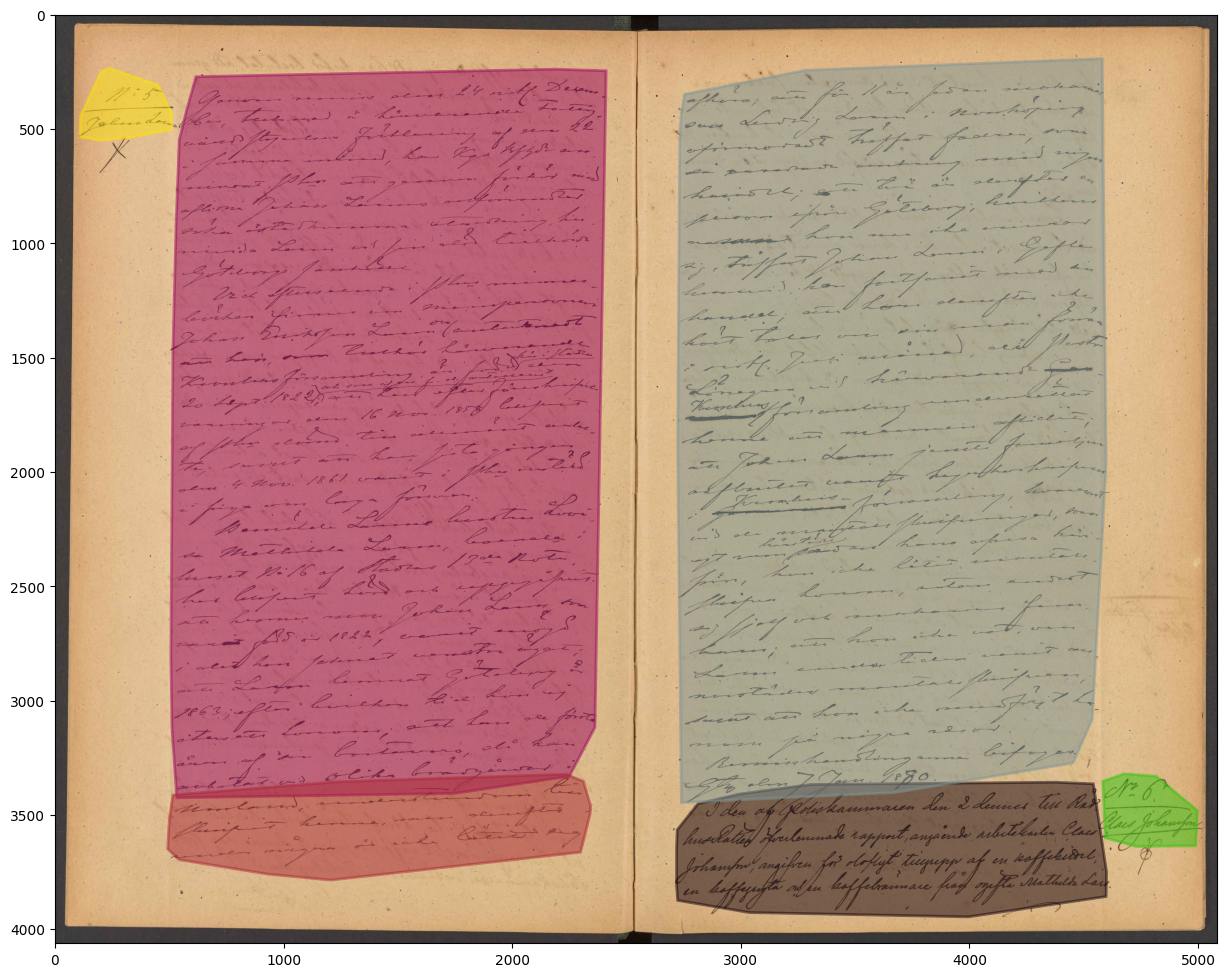

In [35]:
# from src.image_tools.poliskammare import merge_polys, split_regions, ImageDatasetBuilder
from src.image_tools import poliskammare as polis
from shapely.ops import unary_union
from shapely import coverage_union_all
from shapely import Polygon, convex_hull, MultiPoint

import importlib
importlib.reload(polis)


file_idx = 5

image_path = image_files[file_idx]
xml_path = xml_files[file_idx]



xml_data = parse_pagexml_file(xml_path)
builder = polis.ImageDatasetBuilder()

data_generator = builder.create_smooth_region_dataset([(str(image_path), str(xml_path))])
# data = next(data_generator)

regions = polis.split_regions(xml_data)
masks = []


for region in regions:
    merged_lines = polis.merge_polys(region)
    # polys = [Polygon(line.coords.points) for line in region]
    # merged_poly = unary_union(polys)
    # if isinstance(merged_poly.boundary, LineString):
    #     mask = [(int(x), int(y)) for x, y in merged_poly.boundary.coords]
    # elif isinstance(merged_poly.boundary, MultiLineString):
    #     # mask = [(int(x), int(y)) for geom in merged_poly.boundary.geoms for x, y in geom.coords]
        
    #     mask = [(int(x), int(y)) for x, y in merged_poly.boundary.geoms[0].coords]

    hull = convex_hull(MultiPoint(merged_lines))
    masks.append([(int(x), int(y)) for x, y in hull.boundary.coords])


def show_masks(image_path: str, masks: list[list[tuple]], fig_size=15):

    # Show image
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    image = Image.open(image_path)
    ax.imshow(image)


    # Color for lines
    line_colors = [random_color() for _ in range(len(masks))]


    # Color lines
    for idx, poly in enumerate(masks):
        seg_x = [x for (x, y) in poly]
        seg_y = [y for (x, y) in poly]
        ax.fill(
            seg_x, seg_y, 
            facecolor=line_colors[idx], 
            alpha=0.5, 
            edgecolor=line_colors[idx], 
            linewidth=2, label="Segmentation"
        )

show_masks(image_path, masks)